https://medium.com/deeplearningbrasilia/should-you-use-fastai-7ce994de67d0

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=(0.95,1.05),contrast=(0.95,1.05),saturation=(0.95,1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
!ls data/chest_xray/

test  train val


In [4]:
ds = {'train': datasets.ImageFolder('data/chest_xray/train/',data_transforms['train']),
      'valid': datasets.ImageFolder('data/chest_xray/val/', data_transforms['val'])}

In [6]:
dl = {'train':torch.utils.data.DataLoader(ds['train'], batch_size=16, shuffle=True, num_workers=2),
     'valid': torch.utils.data.DataLoader(ds['valid'],batch_size=16, shuffle=True,num_workers=2)}

In [9]:
dataset_sizes = {x: len(ds[x]) for x in ['train', 'valid']}

In [10]:
dataset_sizes

{'train': 5216, 'valid': 16}

In [11]:
class_name = ds['train'].classes

In [12]:
class_name

['NORMAL', 'PNEUMONIA']

In [13]:
inputs, classes = next(iter(dl['train']))

In [14]:
inputs.shape, classes.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [27]:
classes

tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [15]:
frutes = ['orange', 'apple', 'banana', 'pineapple']

In [24]:
ite = iter(frutes)

In [25]:
next(ite)

'orange'

In [26]:
while True:
    try:
        print(next(ite))
    except StopIteration:
        break

apple
banana
pineapple


In [31]:
print(ds['train'].class_to_idx)
print(ds['valid'].class_to_idx)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


In [32]:
name_idx_dict = ds['train'].class_to_idx

In [33]:
type(name_idx_dict)

dict

In [34]:
name_idx_dict['NORMAL']

0

In [36]:
index_names = [k for k,v in name_idx_dict.items() if  v==1]

In [39]:
index_names[0]

'PNEUMONIA'

In [52]:
def show_batch(dataloader,size = 8):

    inputs, classes = next(iter(dataloader))
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inputs = inputs*std + mean
    #inputs = inputs.astype('uint8')
    w,h = size, size
    fig=plt.figure(figsize=(w, h))
    columns = 3
    rows = 2
    ax=[]
    for i in range(1, columns*rows +1):
        ax.append(fig.add_subplot(rows, columns, i))
        index_names = [k for k,v in name_idx_dict.items() if  v==classes[i].item()]
        ax[-1].set_title('Class: '+index_names[0])
        plt.imshow((inputs[i]*255).astype(np.uint8))
    plt.show()

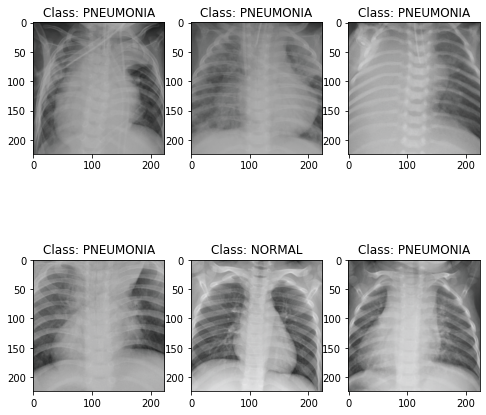

In [54]:
show_batch(dl['train'])

# 4.Creating and training a model with pure Pytorch

In [55]:
mdl = models.resnet50(pretrained=True)
mdl.fc = nn.Linear(2048,2)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/satoc/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [56]:
# making sure I'm using a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [61]:
mdl = mdl.to(device)

# making sure I'm not updating the weights for the conv layers
for child in mdl.children():
    for param in child.parameters():
        param.requires_grad = False

for parm in mdl.fc.parameters():
    param.requires_grad = True
    
# set loss
criterion = nn.CrossEntropyLoss()

#Training only the fully connected layer
optimizer_ft = optim.AdamW(mdl.parameters(),lr=1e-2)

In [62]:
#using cyclic LRs and MOmentuns
scheduler = lr_scheduler.CyclicLR(optimizer_ft, base_lr=1e-3, max_lr=1e-2, cycle_momentum=False)
#scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [65]:
#defining the traininng function
def fit_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('_' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects= 0
            
            #Iterate over data.
            for inputs, labels in dl[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    #loss.requires_grad = True
                    
                    #backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss  += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(phase, epoch_loss, epoch_acc) )
            
            #deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts =copy.deepcopy(model.state_dict())
                
        print()
        
    time_epapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_epapsed// 60, time_epapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    #load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
mdl_fitted = fit_model(mdl, criterion, optimizer_ft, scheduler, num_epochs=3)

Epoch 0/2
__________


In [ ]:
1+1

In [60]:
for child in mdl.children():
    print('section')
    print(child)

section
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
section
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
section
ReLU(inplace=True)
section
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
section
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256,